In [1]:
from deepcheese.data_loader.kis_loader import KisLoader
from deepcheese.data_loader.indi_loader import IndiLoader
from deepcheese.dataset.moving_window import MovingWindowDataset, MultipleMovingWindowDataset, MovingWindow3dDataset
from deepcheese.model.CNN import CNN3d, CNN

import torch
import numpy as np

In [2]:
moving_windows = MovingWindow3dDataset(KisLoader())

[39853   551]
[59381   316]
[69002  1164]
[70315   166]
[70605  2279][67507   747]

[66772  1122]
[67259  2111]
[69763   247]
[70640  1309]
[69891  1230]
[71075  1187]
[77171  4107]
[69789  3040]
[72048  3420]
[73084   755]
[75114  1024]
[78840   239]
[72805   441]
[76951  2865]
[78344  1466]
[86247  2258]
[91527  1009]
[91282  2877]
[68588   554]
[70648   696]
[65681  1902][65199  1384]

[76199   610]
[62939  1489]
[80398  1181]
[85707  2337][71761   910]

[74855  3045]
[52880   134]
[69554  2526]
[45312  2215]
[83385  1433]
[82990  1595]
[85121   415]
[72713  2337]
[71054  1015]
[69833   326]
[77197  1965]
[81914  2111]
[76404  1485]
[77065  3273]
[90806  1321][84829   922]

[66764   782]
[72147   749]
[65989   933]
[37859  1176]
[76704  4050]
[56099   919]
[64742   333]
[77404  3186]
[80619  1783]
[65137  1885]
[65815   942]
[67893   302]
[82318  2795]
[65925  1082]
[70436  1530]
[63592  1334]
[84705  2887]
[86642  1602]
[55687   836]
[86703  2281]
[78313  6055]
[75225   880]
[77236

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN3d().to(device)
model.load_state_dict(torch.load("model3.pth"))
print(model)

CNN3d(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=3072, out_features=2, bias=True)
  (relu): ReLU()
  (max_pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [7]:
train_loader, test_loader = moving_windows.get_data_loader()

In [356]:
test_idx = 0
test_example_loader = test_loader[test_idx]

pred = []
conf = []
labels = []

model.eval()

with torch.no_grad():
    for data, label in test_example_loader:
        data = data.to(device)
        output = model(data)
        
        pred.append(torch.argmax(output, dim=1).cpu().detach().numpy())
        conf.append(torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy())
        labels.append(label)
    
pred = np.concatenate(pred, 0)
conf = np.concatenate(conf, 0)
labels = np.concatenate(labels, 0)

In [357]:
pred = conf[:, 1] > 0.99

In [358]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(np.bincount(labels), np.bincount(pred))
print(len(labels), len(pred))
print(accuracy_score(labels, pred))
print(classification_report(labels, pred))
print(confusion_matrix(labels, pred, normalize='true'))

[67893   302] [68163    32]
68195 68195
0.9959234547987389
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67893
           1       0.88      0.09      0.17       302

    accuracy                           1.00     68195
   macro avg       0.94      0.55      0.58     68195
weighted avg       1.00      1.00      0.99     68195

[[9.99941084e-01 5.89162358e-05]
 [9.07284768e-01 9.27152318e-02]]


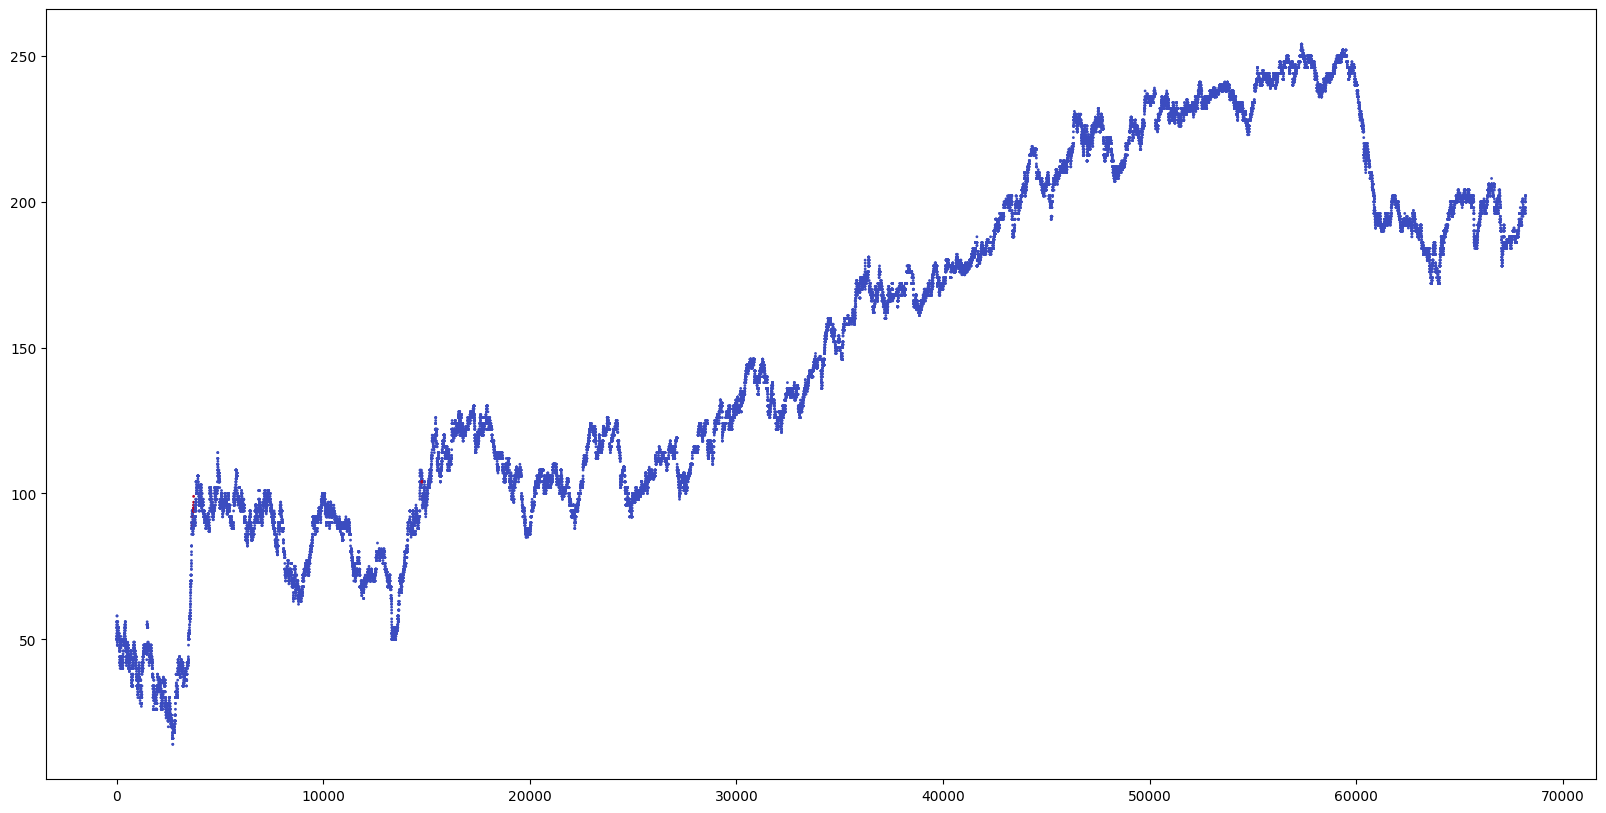

In [359]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(moving_windows.get_test_day(test_idx)._mid_price) - 298), moving_windows.get_test_day(test_idx)._mid_price[298:], s=1, c=pred, cmap='coolwarm')

In [378]:
result = []
short_result = []
start_idx = moving_windows.get_test_day(test_idx)._start_idx
test_day = moving_windows.get_test_day(test_idx)

for idx in range(len(pred) - start_idx - 2500):
    if pred[idx] == 1:
        j = 10
        latest = test_day._mid_price[start_idx + idx + j]
        while -test_day._mid_price[start_idx + idx + j] + latest > -20 and start_idx + idx + j < len(pred) - start_idx - 2501:
            j += 1
            latest = min(test_day._mid_price[start_idx + idx + j], latest)
            
        amt = test_day._best_ask[start_idx + idx + j] - test_day._best_bid[start_idx + idx]
        print(amt, j)
        result.append(test_day._best_ask[start_idx + idx] - test_day._best_bid[start_idx + idx + j])
        short_result.append(moving_windows.get_test_day(test_idx)._best_ask[start_idx + idx] - moving_windows.get_test_day(test_idx)._best_bid[start_idx + idx + 1000])

print(np.sum(result))
print(np.mean(result))
print(np.mean(short_result))

[18] 50
[16] 47
[18] 43
[15] 33
[27] 308
[24] 304
[22] 303
[22] 302
[22] 301
[22] 300
[19] 299
[16] 298
[14] 297
[15] 296
[16] 295
[16] 294
[12] 293
[13] 292
[12] 291
[16] 290
[14] 289
[14] 288
[14] 287
[15] 286
[16] 284
[3] 557
[2] 556
[1] 555
[1] 554
[2] 553
[2] 552
[2] 551
-566
-17.6875
-11.28125
